In [21]:
#import theano 
from scipy.integrate import odeint
import math 
import numpy as np
import theano 
from theano import *
import matplotlib.pyplot as plt

%matplotlib notebook


theano.config.exception_verbosity= 'high'
THEANO_FLAGS='optimizer=fast_compile'

# Lotka Volterra example
\begin{align}
\frac{dX}{dt}&=\alpha X - X Y\\
\frac{dY}{dt}&=\beta X Y -Y,
\end{align}
where $\alpha, \beta$ are the model parameters.

In this example we would introduce a bit more efficient way of writting the model solver. We have two methods one which return the forward solution and one that returns forward solution plus the sensitivities. This way we can use each method according to need (gradient vs non-gradient based usage). Also the following code makes it easy to quickly find the required derivatives using SymPy or Mathematica and plug those in.

In [22]:
class LotkaVolterraModel(object):
    
    def __init__(self, y0=None):

        if y0 is None:
            self._y0 = np.array([1, 0.5], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)

    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
 
        alpha, beta = [float(x) for x in parameters]

        def r(y, t, p):
            X, Y = y
            dX_dt = alpha*X - X*Y
            dY_dt = beta*X*Y - Y
            return dX_dt, dY_dt

        if sensitivities:
            def jac(y):
                X, Y = y
                ret = np.empty((2, 2))
                ret[0, 0] = alpha -Y
                ret[0, 1] = - X
                ret[1, 0] = beta*Y
                ret[1, 1] = beta*X -1
                return ret

            def dfdp(y):
                X, Y = y
                ret = np.empty((2, 2))
                ret[0, 0] = X
                ret[0, 1] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = X*Y
                
                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0:2]
                dydp = y_and_dydp[2:].reshape((2, 2))

                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)

                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros(6)
            y0[0:2] = self._y0
            result = odeint(rhs, y0, times, (parameters,))
            values = result[:, 0:2]
            dvalues_dp = result[:, 2:].reshape((len(times), 2, 2))
            return values, dvalues_dp
        else:
            values = odeint(r, self._y0, times, (parameters,))
            return values
        
ode_model = LotkaVolterraModel()


In [ ]:
class ODEGradop(theano.Op):
    def __init__(self,jac_sens):
        self.jac_sens = jac_sens

    def make_node(self, x, v):
        x = theano.tensor.as_tensor_variable(x)
        v = theano.tensor.as_tensor_variable(v)
        node = theano.Apply(self, [x, v], [v.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        v = inputs_storage[1]
        out = output_storage[0]
        out[0] = np.asarray(self.jac_sens(x, v))
        
class ODEop(theano.Op):

    def __init__(self, state, jac_sens):
        self.state = state
        self.jac_sens =jac_sens

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = np.asarray(self.state(x))

    def grad(self, inputs, output_grads):
        x = inputs[0]
        v = output_grads[0]
        op = self

        grad_op = ODEGradop(self.jac_sens)
        grad_op_apply = grad_op(x, v)
        
        return [grad_op_apply]

# A more efficient cached solver

If you have noticed carefully the logistic model implementation then you have found that we are solving the state as well as sensitivities twice for the same parameter values in both the forward and backward path. This is highly inefficient for more complex model and thus it is better to cache the solutions when using the forward direction and use the cached values in backward path. This is exactly what we would do now using a cached solver.

In [65]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
        
        self.times = times
        self.n_params = n_params
        self.n_outputs = n_outputs
        self.cachedParam = np.zeros(n_params)
        self.cachedJac = np.zeros((len(times), n_outputs, n_params))
        self.cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self,x):
        
        if np.all(x==self.cachedParam):
            #print('passing cached')
            state, jac = self.cachedState, self.cachedJac
            
        else:
            
            state, jac = ode_model.simulate_with_sensitivities(x, times)
        
        return state, jac
times = np.linspace(0, 10, 10)
cached_solver=solveCached(times, 2, 2)        

In [66]:
def state(x):

    State, Jac = cached_solver(np.array(x,dtype=np.float64))
    cached_solver.cachedState, cached_solver.cachedJac, cached_solver.cachedParam = State, Jac, x
    return State.reshape((2*len(State),))

def jac_sens(x, v):
    
    backProp = cached_solver(np.array(x,dtype=np.float64))[1].reshape((2*len(times),len(x)))
    return backProp.T.dot(v)


<IPython.core.display.Javascript object>


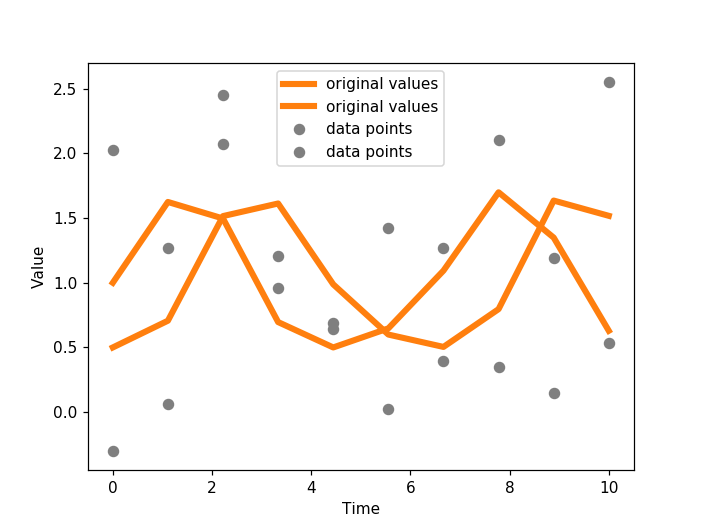

In [67]:
sigma=0.5
real_params = [1.,1.]
sol=ode_model.simulate(real_params, times)
Y=sol+np.random.randn(10,2)*sigma

plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

In [72]:
import pymc3 as pm
theano.config.floatX = 'float64'
theano.config.compute_test_value = 'ignore'

LV_op = ODEop(state, jac_sens)

with pm.Model() as Lotka_model:
    # We place informative Normal priors on the two model parameters
    alpha = pm.Normal('alpha', mu=1, sd=1)
    beta = pm.Normal('beta', mu=1, sd=0.5)
    
    # Here we call the forward model
    forward=LV_op([alpha,beta])
    
    # We place Half-Normal prior on the noise parameter
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # We reshape the theano op output as Times X states
    mu = forward.reshape((10,2))
    
    
    # Likelihood (sampling distribution) of observations
    
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)



  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


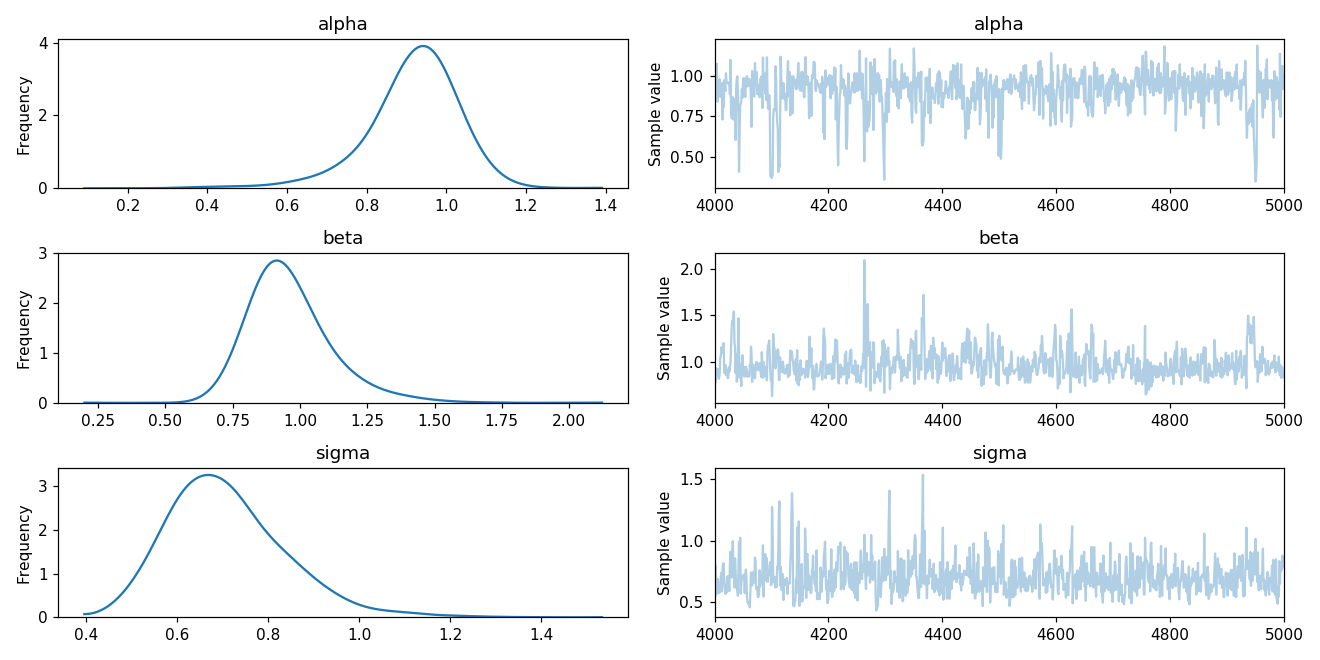

100%|██████████| 5000/5000 [02:30<00:00, 33.17it/s]


In [73]:
with Lotka_model:  
    # run NUTS with live plotting 
    trace = pm.sample(3000, chains=1, tune=2000, live_plot=True, refresh_every=100)


In [74]:
with Lotka_model:  
    # run NUTS with multiple chains for Rhat 
    traceMulti = pm.sample(5000, chains=2, n_cores=4, tune=2000, nuts_kwargs={'target_accept':0.9})
    

/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
 31%|███▏      | 2200/7000 [01:06<02:19, 34.36it/s]

In [76]:
pm.summary(traceMulti)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.919105,0.112609,0.001890,0.704506,1.130252,3265.217407,0.999900
beta,0.957949,0.142880,0.002215,0.722690,1.255223,4204.469394,0.999905
sigma,0.709867,0.128398,0.001831,0.491258,0.969430,4928.625428,0.999901


In [77]:
traceMulti['diverging'].sum()

0